In [1]:
import sys
import warnings
from enum import Enum
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.utils import io
from rdkit import Chem
from tqdm import tqdm

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
from scipy.stats import linregress

with io.capture_output() as captured:

    import mbuild
    import MDAnalysis as mda
    import mdtraj
    import nglview
    import openmm
    from MDAnalysis.analysis import rms
    from openff import interchange, models, toolkit, utilities
    from openff.interchange.components._packmol import UNIT_CUBE, pack_box
    from openff.toolkit import topology
    from openff.units import unit

# Build

In [2]:
class Mol(Enum):
    butanol = 'butanol'
    ocm = 'ocm'
    dmag = 'dmag'
    peta = 'peta'


RD_MOLECULES = {
    Mol.ocm:
    Chem.MolFromSmiles("CC(C(OCCOC(OCCOCCOC(OCCOC(C(C)=C)=O)=O)=O)=O)=C"),
    Mol.dmag: Chem.MolFromSmiles("C=C(C)C(OCCOC(C(C)=C)=O)=O"),
    Mol.peta: Chem.MolFromSmiles("C=CC(OCC(COC(C=C)=O)(COC(C=C)=O)CO)=O"),
    Mol.butanol: Chem.MolFromSmiles("OCCCC"),
}

OFF_MOLECULES = {}
for molecule_type, rdkit_mol in RD_MOLECULES.items():
    mol = toolkit.Molecule.from_rdkit(rdkit_mol)
    OFF_MOLECULES[molecule_type] = mol
    mol.generate_conformers(n_conformers=1)
    mol.name = molecule_type.name

    for atom in mol.atoms:
        atom.metadata["residue_name"] = molecule_type.name.upper()
    mol.add_hierarchy_scheme(
        iterator_name="residue",
        uniqueness_criteria=["residue_name"],
    )

Draw.MolsToGridImage(
    RD_MOLECULES.values(),
    useSVG=True,
    molsPerRow=4,
    legends=[i.name for i in RD_MOLECULES.keys()],
)

NameError: name 'Draw' is not defined

In [3]:
class Box:
    box = None
    ff = toolkit.ForceField("openff_unconstrained-2.1.0.offxml")

    def __init__(self, x, rho, substance: Mol):
        self.solvent_n = int(x)
        self.substance_n = int((100 - x))
        self.substance = substance
        self.rho = rho

    def __repr__(self) -> str:
        return f"<Box: {self.substance}= {self.substance_n} ({self.solvent_n}), rho={self.rho} mg/cm3>"

    def pack(self, tol=0.5):
        solvent = OFF_MOLECULES[Mol.butanol]
        substance = OFF_MOLECULES[self.substance]
        if self.substance_n == 0:
            molecules = [solvent]
            n_molecules = [100]
        elif self.substance_n == 100:
            molecules = [substance]
            n_molecules = [100]
        else:
            molecules = [solvent, substance]
            n_molecules = [self.solvent_n, self.substance_n]
        self.box = pack_box(
            molecules=molecules,
            number_of_copies=n_molecules,
            mass_density=self.rho * unit.kilogram / unit.meter**3,
            tolerance=tol * unit.angstrom,
            box_shape=UNIT_CUBE,
        )

    def parametrize(self):
        self.system = interchange.Interchange.from_smirnoff(
            force_field=self.ff,
            topology=self.box,
        )

    def minimaze(self):
        self.system.minimize()

    def save(self, path):
        with open(path, "w") as file:
            box_j = self.box.to_json()
            data = {
                "solvent_n": self.solvent_n,
                "substance": self.substance,
                "rho": self.rho,
            }
            box_j = f"{data} ###" + box_j
            file.write(box_j)

    @classmethod
    def load(cls, path):
        with open(path, "r") as file:
            box_j = file.read()
            data, box_j = box_j.split("###")
            data = eval(data)
            box = Box(
                x=int(data["solvent_n"]),
                rho=data["rho"],
                substance=data["substance"],
            )
            box.box = toolkit.Topology.from_json(box_j)

        return box

In [4]:
res = {
    "butanol": [
        (100, 1000),
    ],
    "dmag": [
        (0, 1069),
        (11, 1069),
        (22, 1050),
        (35, 1029),
        (39, 1019),
    ],
    "ocm": [
        (0, 1720),
        (12, 1580),
        (22, 1569),
        (31, 1550),
        (38, 1539),
        (44, 1530),
        (49, 1510),
        (54, 1489),
        (58, 1490),
    ],
    "peta": [
        (0, 1200),
        (19, 1180),
        (30, 1159),
        (41, 1140),
        (49, 1110),
    ],
}

In [67]:
boxes = []
for substance, combinations in res.items():
    for x, rho in combinations:
        box = Box(
            x=x,
            rho=rho,
            substance=substance,
        )
        try:
            box.pack(tol=1)
            box.save(path=f"./boxes/box_{substance}_{x}_{rho}.json")
        except:
            pass

        try:
            box.pack(tol=0.5)
            box.save(path=f"./boxes/box_{substance}_{x}_{rho}.json")
        except:
            continue

boxes

[]

In [5]:
b = Box.load("boxes/box_ocm_12_1580.json")
with io.capture_output() as captured:
    view = b.box.visualize()
# view

In [6]:
b.parametrize()

In [7]:
b.minimaze()

# Simulation

In [90]:
class MSDReporter:

    def __init__(self, interval, simulation, dt):
        self.interval = interval
        self.dt = dt.value_in_unit(openmm.unit.second)
        self.ids = {}

        self.data = {'Time': np.array([])}
        self.atom_map = {}
        self.positions = {}
        self.start_positions = {}

        self.residues = list({residue.name for residue in simulation.topology.residues()})
        state0 = simulation.context.getState(getPositions=True, enforcePeriodicBox=False)
        atoms = list(simulation.topology.atoms())
        for residue_name in self.residues:
            atom_ids = [
                atoms.index(atom) for atom in atoms if MSDReporter.is_selected(atom, residue_name)
            ]

            self.atom_map[residue_name] = atom_ids

            positions = state0.getPositions(asNumpy=True).value_in_unit(openmm.unit.centimeter)
            self.start_positions[residue_name] = positions[atom_ids]

            self.data.update({residue_name: np.array([])})

    @staticmethod
    def is_selected(
        atom: openmm.app.topology.Atom,
        residue: str,
    ):
        selected_atoms = [openmm.app.Element.getBySymbol(symbol) for symbol in ['O', 'C', 'N']]

        select_residue = atom.residue.name == residue
        select_atom = atom.element in selected_atoms
        return select_residue and select_atom

    def describeNextReport(self, simulation):
        steps = self.interval - simulation.currentStep % self.interval
        return (steps, True, False, False, False, False)

    def report(self, simulation, state):
        for residue in self.residues:
            atom_ids = self.atom_map[residue]
            positions = state.getPositions(asNumpy=True).value_in_unit(openmm.unit.centimeter)[
                atom_ids
            ]
            start_positions = self.start_positions[residue]

            msd = np.mean(np.linalg.norm((start_positions - positions), axis=1) ** 2)
            self.data[residue] = np.append(self.data[residue], msd)
        time = state.getStepCount() * self.dt
        self.data['Time'] = np.append(self.data['Time'], time)

    @property
    def df(self):
        return pd.DataFrame(self.data)


def create_simulation(
    box: Box,
    dt=1,
    T=25,
    save_dir: Path = Path("simulations"),
):
    check_freq = 100
    # Integration options
    dt = dt * openmm.unit.femtoseconds  # simulation timestep
    temperature = (T + 273) * openmm.unit.kelvin  # simulation temperature
    friction = 1 / openmm.unit.picosecond  # friction constant

    integrator = openmm.LangevinIntegrator(temperature, friction, dt)

    simulation = box.system.to_openmm_simulation(
        integrator=integrator,
        # platform=openmm.Platform.getPlatformByName('CUDA'),
    )
    # simulation.context.setVelocitiesToTemperature(temperature)
    substance = box.substance
    x = box.substance_n
    rho = box.rho

    sim_dir = save_dir / Path(f"box_{substance}_{x}_{rho}")
    sim_dir.mkdir(parents=True, exist_ok=True)
    box.system.to_pdb(f"{sim_dir}/box_min.pdb")
    simulation.reporters.append(openmm.app.StateDataReporter(sys.stdout, check_freq, step=True))

    print('Equilibration')
    simulation.minimizeEnergy()
    simulation.context.setVelocitiesToTemperature(temperature)
    simulation.context.reinitialize(preserveState=True)
    simulation.step(1000)

    msdReporter = MSDReporter(100, simulation, dt)
    simulation.reporters.append(msdReporter)
    simulation.currentStep = 0
    return simulation, save_dir / sim_dir, msdReporter

In [92]:
simulation, traj_path, msdReporter = create_simulation(b, dt=1)
print('Product')
simulation.step(10000)

Equilibration
#"Step"
1000
Product
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


# Results

OCM:  0.17 cm2/day)
BUT:  0.25 cm2/day)


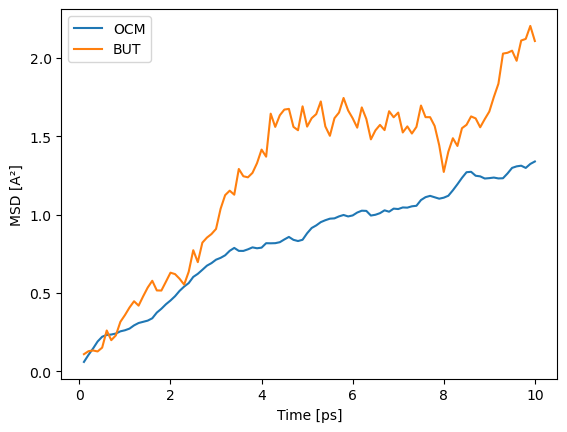

In [93]:
df = msdReporter.df

for mol_type in list(df.columns)[1:]:
    linear_model = linregress(df['Time'], df[mol_type])
    slope = linear_model.slope
    plt.plot(df['Time']*10**12, df[mol_type]*10**16,label=mol_type)
    D = slope / 6*24*60*60
    print(f'{mol_type}: {D: >5.2f} cm2/day)')

plt.xlabel('Time [ps]')
plt.ylabel('MSD [A²]')
plt.legend();